<div style="background-color:#1e1e1e; padding:25px; border-radius:10px; display:table; width:100%;">

  <!-- Left column: text -->
  <div style="display:table-cell; vertical-align:top; width:70%; padding-right:10px;">
    <h1 style="color:#4FC3F7; margin-bottom:10px;">Hands-On Part B: Personalization Methods</h1>

  <p style="font-size:18px; font-style:italic; color:#cccccc;">
    Workshop on T1D Simulator and Digital Twins for Personalized Care
  </p>

  <p style="font-size:15px; line-height:1.6; color:#dddddd;">
fill
  </p>
  </div>

  <!-- Right column: logo -->
  <div style="display:table-cell; vertical-align:middle; text-align:left; width:30%; padding-right:50px;">
    <img src="https://micelab.udg.edu/wp-content/uploads/2022/08/MICElab-letras_png-300x119.png" alt="MiceLab Logo" style="height:80px; border-radius:8px;">
  </div>

</div>


<h2 style="color:#4FC3F7; border-bottom:2px solid #4FC3F7; padding-bottom:4px;">
0. Imports &amp; Set-Up
</h2>

In [1]:
import sys
import os

sys.path.append(os.path.abspath(".."))
sys.path.append(os.path.abspath("../scripts"))

In [2]:
from pathlib import Path
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass

from sklearn.model_selection import train_test_split

from datetime import datetime
from types import SimpleNamespace
import pytz
from tqdm import tqdm
from scripts.data_classes import TrainingData
from scripts.gan import GANModel
from scripts.simulate import SimulatorVAEGAN

2025-09-21 17:12:40.285566: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-21 17:12:40.287645: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-21 17:12:40.333069: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-21 17:12:40.334867: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-21 17:12:41.829565: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Check GPU availability for TensorFlow, not essential.

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPUs:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.13.0
Num GPUs Available: 0
GPUs: []


In [4]:
import os, sys, contextlib, io

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'   # still useful for later logs
os.environ['ABSL_LOG_LEVEL']      = '3'

@contextlib.contextmanager
def mute_tensorflow_startup():
    """Silence C++ factory/placer warnings emitted during the first TF import."""
    stderr_fileno = sys.stderr.fileno()
    with open(os.devnull, 'w') as devnull:
        saved_stderr = os.dup(stderr_fileno)
        os.dup2(devnull.fileno(), stderr_fileno)   # redirect to /dev/null
        try:
            yield
        finally:
            os.dup2(saved_stderr, stderr_fileno)   # restore stderr
            os.close(saved_stderr)

with mute_tensorflow_startup():
    import tensorflow as tf

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior() # essential for indexing tensors, code crashes without this

<h2 style="color:#4FC3F7; border-bottom:2px solid #4FC3F7; padding-bottom:4px;">
1. Load Model & Data
</h2>

Setup path and model name.

In [5]:
path_to_model = "../misc/"
model_name = "pretrained-model.h5"

Load the .h5 using the `load_model` method from keras.

In [6]:
model_filename = Path(path_to_model, model_name)
pretrained_vae_model = tf.keras.models.load_model(model_filename)

In [7]:
path_df = Path("../data/data_processed.csv")

df = pd.read_csv(path_df)

display(df.head())

,ID,BG,PI,RA
0,11_0,134.0,0.000000,0.0
1,11_0,125.0,0.000271,0.0
2,11_0,132.0,0.001510,0.0
3,11_0,132.0,0.003488,0.0
4,11_0,132.0,0.006741,0.0


<h2 style="color:#4FC3F7; border-bottom:2px solid #4FC3F7; padding-bottom:4px;">
2. S
</h2>

In [8]:
settings = SimpleNamespace()

In [9]:
# preprocessing settings
settings.random_state = 0
settings.scaler_range = (0, 1)
settings.glucose_dim = int(90/5) # prediction horizon 90 min, data

In [10]:
# training settings
settings.in_data_shape = (1, 1)
settings.weight_clip = 1

settings.learning_rate_discriminator = 0.0001
settings.learning_rate_generator = 1e-04
settings.ratio_generator_losses = [1, 1]

settings.n_epochs_gan = 50
settings.batch_size_gan = 32

settings.y_real_label = 1
settings.y_fake_label = -1

In [11]:
# simulation settings
settings.simulation_length = 2
settings.padding_steps = 12 # 12*5min = 1h padding

In [12]:
# don't modify these unless you know what you're doing
settings.gan_inputs = ['BG', 'PI', 'RA']
settings.scalers_path = '../misc/'
settings.out_data_shape = (1, settings.glucose_dim)
settings.latent_dimensions = settings.glucose_dim

In [13]:
def manual_minmax_scaling(data: np.ndarray, scaler_range: tuple) -> tuple[np.ndarray, float, float]:
    """
    Perform manual min-max scaling on the data.

    Args:
        data (np.ndarray): Data to scale.
    Returns:
        Tuple[np.ndarray, float, float]: Scaled data, minimum value, and maximum value.
    """
    lower_bound = scaler_range[0]
    upper_bound = scaler_range[1]
    min_val = np.min(data)
    max_val = np.max(data)
    scaled_data = lower_bound + (upper_bound - lower_bound) * (data - min_val) / (max_val - min_val)

    return scaled_data, min_val, max_val

def individual_min_max_scaling(
    df: pd.DataFrame, base_output_dir: Path, scaler_range: tuple, gan_inputs: list
) -> pd.DataFrame:
    """
    Perform individual min-max scaling on the dataframe columns.
    Scale all three columns the same way and save only the scalers for 'BG'.

    Args:
        df (pd.DataFrame): Dataframe to scale.
        base_output_dir (Path): Directory to save the scalers.
    Returns:
        pd.DataFrame: Scaled dataframe.
    """
    scalers: dict[str, list[float]] = {'BG_min': [], 'BG_max': []}
    scaled_dfs: list[pd.DataFrame] = []

    for column in gan_inputs:
        if column not in ['BG', 'IG']:
            df[f'sc{column}'], _, _ = manual_minmax_scaling(df[column], scaler_range)

    df['scBG'], min_val, max_val = (manual_minmax_scaling(df['BG'], scaler_range))

    scalers['BG_min'].append(min_val)
    scalers['BG_max'].append(max_val)

    scaled_dfs.append(df)

    scaled_df = pd.concat(scaled_dfs, ignore_index=True)
    scaled_df = scaled_df.sort_values(by=['ID', 'iteration']).reset_index(drop=True)

    save_scalers(pd.DataFrame(scalers), base_output_dir)

    return scaled_df

def save_scalers(scalers_df: pd.DataFrame, base_output_dir: Path) -> None:
    """
    Save the scalers to a file.

    Args:
        scalers (Dict[str, List[float]]): Dictionary containing the scalers.
        base_output_dir (Path): Directory to save the scalers.
    """
    scalers_file: Path = Path(base_output_dir, 'bg_scalers.joblib')
    joblib.dump(scalers_df, scalers_file)

In [14]:
df_scaled = df.copy(deep=True)

df_scaled['iteration'] = df_scaled.groupby('ID').cumcount()
df_scaled = individual_min_max_scaling(df_scaled, Path(settings.scalers_path), (-1, 1), settings.gan_inputs)
df_scaled

,ID,BG,PI,RA,iteration,scPI,scRA,scBG
0,11_0,134.0,0.000000,0.000000,0,-1.000000,-1.000000,-0.246032
1,11_0,125.0,0.000271,0.000000,1,-0.999805,-1.000000,-0.317460
2,11_0,132.0,0.001510,0.000000,2,-0.998915,-1.000000,-0.261905
3,11_0,132.0,0.003488,0.000000,3,-0.997494,-1.000000,-0.261905
4,11_0,132.0,0.006741,0.000000,4,-0.995158,-1.000000,-0.261905
...,...,...,...,...,...,...,...,...
1723,290_0,70.0,1.402729,0.052132,859,0.007723,-0.978783,-0.753968
1724,290_0,69.0,1.373106,0.047064,860,-0.013558,-0.980846,-0.761905
1725,290_0,69.0,1.344499,0.042466,861,-0.034110,-0.982717,-0.761905
1726,290_0,69.0,1.316954,0.038300,862,-0.053898,-0.984412,-0.761905


In [15]:
def pack_data(df) -> None:
    """
    Pack the data into vectors for each feature (BG).

    This method creates packed vectors for blood glucose (BG)
    by sliding a window over the time series data. The packed data is then
    stored in new columns in the DataFrame.
    """
    df = df.fillna(0)  # Fill NaN values with 0

    # Pack blood glucose data
    packed_bg_vectors: np.ndarray = np.array(
        [
            df.iloc[i : i + 18]['scBG'].values
            for i in tqdm(range(len(df) - (18 - 1)), desc='Packing BG')
        ]
    )

    df = df.iloc[: len(packed_bg_vectors)]
    df['scBG_packed'] = list(packed_bg_vectors)
    df.reset_index(drop=True, inplace=True)
    return df

In [16]:
df_packed = pack_data(df_scaled)
display(df_packed)

Packing BG: 100%|██████████| 1711/1711 [00:00<00:00, 17487.51it/s]


,ID,BG,PI,RA,iteration,scPI,scRA,scBG,scBG_packed
0,11_0,134.0,0.000000,0.000000,0,-1.000000,-1.000000,-0.246032,"[-0.24603174603174605, -0.31746031746031744, -..."
1,11_0,125.0,0.000271,0.000000,1,-0.999805,-1.000000,-0.317460,"[-0.31746031746031744, -0.26190476190476186, -..."
2,11_0,132.0,0.001510,0.000000,2,-0.998915,-1.000000,-0.261905,"[-0.26190476190476186, -0.26190476190476186, -..."
3,11_0,132.0,0.003488,0.000000,3,-0.997494,-1.000000,-0.261905,"[-0.26190476190476186, -0.26190476190476186, -..."
4,11_0,132.0,0.006741,0.000000,4,-0.995158,-1.000000,-0.261905,"[-0.26190476190476186, -0.2698412698412699, -0..."
...,...,...,...,...,...,...,...,...,...
1706,290_0,189.0,1.856360,0.266009,842,0.333612,-0.891737,0.190476,"[0.19047619047619047, 0.10317460317460325, 0.0..."
1707,290_0,178.0,1.853454,0.243603,843,0.331524,-0.900856,0.103175,"[0.10317460317460325, 0.031746031746031855, 0...."
1708,290_0,169.0,1.843510,0.222789,844,0.324381,-0.909327,0.031746,"[0.031746031746031855, 0.0, -0.047619047619047..."
1709,290_0,165.0,1.827765,0.203503,845,0.313070,-0.917176,0.000000,"[0.0, -0.04761904761904767, -0.103174603174603..."


In [17]:
dict_inputs = ['BG', 'scBG_packed', 'PI', 'RA', 'scPI', 'scRA']
data_dict = {column: np.array(df_packed[column].tolist(), dtype=np.float32).reshape(df_packed.shape[0], 1, -1) for column in dict_inputs}

In [18]:
def load_training_data(df, dict_inputs) -> TrainingData:
    train_data_dict = {}
    for input_name in dict_inputs:
        if input_name == 'scBG_packed':
            train_data_dict['scBG'] = df[f'{input_name}']
        elif input_name in ['BG', 'PI', 'RA']:
            pass
        else:
            train_data_dict[f'{input_name}'] = df[f'{input_name}']

    train_data = TrainingData(**train_data_dict)
    return train_data

In [19]:
training_data = load_training_data(data_dict, dict_inputs)

In [20]:
gan = GANModel(settings, pretrained_vae_model)

timestamp = datetime.now(pytz.timezone('Europe/Madrid')).strftime("%Y%m%d_%H%M%S")
gan.gan_model.save(f"../misc/gan_model_{timestamp}.h5")

/home/oriol/workspace/t1d-data-based-digital-twin/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
import netron
netron.start(f"../misc/gan_model_{timestamp}.h5")

Serving '../misc/gan_model_20250921_171244.h5' at http://localhost:8080


('localhost', 8080)

In [22]:
try:
    history = gan.train(training_data)
except KeyboardInterrupt:
    print('Process interrupted by user')

GAN Training:  13%|█▎        | 355/2650 [00:31<03:22, 11.33step/s]

Process interrupted by user


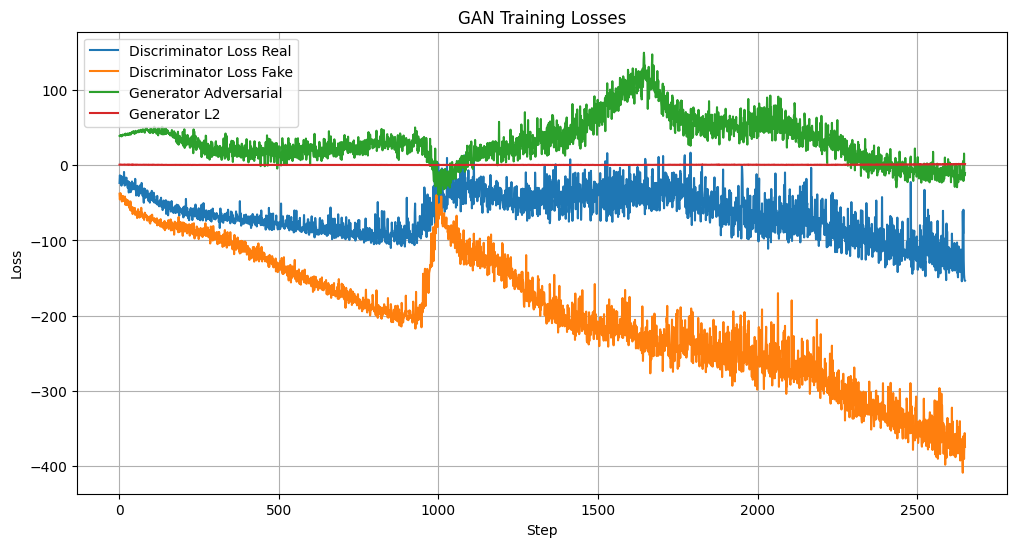

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history['step'], history['d_loss_real'], label='Discriminator Loss Real')
plt.plot(history['step'], history['d_loss_fake'], label='Discriminator Loss Fake')
plt.plot(history['step'], history['g_adversarial'], label='Generator Adversarial')
plt.plot(history['step'], history['g_l2'], label='Generator L2')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('GAN Training Losses')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
timezone = pytz.timezone('Europe/Madrid')
timestamp = datetime.now(timezone).strftime('%Y%m%d_%H%M%S')
gan.g_model.save(f'../misc/generator_model_{timestamp}.h5')

/home/oriol/workspace/t1d-data-based-digital-twin/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


## Simulation

In [23]:
@dataclass
class SimulationData:
    """
    Data class containing the simulation dynamical inputs, results and some minor settings.
    """
    # Blood Glucose
    gen_bg_scaled_arrays: np.ndarray

    real_bg_scaled: np.ndarray
    real_bg_unscaled: np.ndarray
    gen_bg_unscaled: np.ndarray = None

    PI_scaled: np.ndarray = None
    RA_scaled: np.ndarray = None
    PA_scaled: np.ndarray = None
    IG_scaled: np.ndarray = None

    # Plotting data
    PI_unscaled: np.ndarray = None
    RA_unscaled: np.ndarray = None
    PA_unscaled: np.ndarray = None
    IG_unscaled: np.ndarray = None

In [24]:
def load_patient_sim_data(data_dict, simulation_length: int) -> SimulationData:
    real_bg_unscaled = data_dict['BG']  # take the original vector to compare against the generated profile
    real_bg_scaled = data_dict['scBG_packed']  # this is packed
    gan_inputs = ['BG', 'scBG_packed', 'PI', 'RA']

    # Calculate the number of days to simulate
    days_to_simulate = min(len(real_bg_unscaled) / 288, simulation_length)
    time_steps = int(288 * days_to_simulate)

    sim_data_dict = {
        'real_bg_unscaled': real_bg_unscaled.ravel()[:time_steps],
        'real_bg_scaled': real_bg_scaled[:, 0, 0][:time_steps],
    }

    for input_name in gan_inputs:
        if input_name != 'BG' and input_name != 'scBG_packed':
            sim_data_dict[f'{input_name}_scaled'] = data_dict[f'sc{input_name}'][:time_steps]
            sim_data_dict[f'{input_name}_unscaled'] = data_dict[input_name][:time_steps]

    sim_data_dict['gen_bg_scaled_arrays'] = np.zeros(
        (
            1,
            time_steps,
            time_steps + 18,
        )
    )

    sim_data = SimulationData(**sim_data_dict)
    return sim_data

In [25]:
timestamp = '20250921_155140'

In [26]:
# load from misc the .h5
generator = tf.keras.models.load_model(f'../misc/generator_model_{timestamp}.h5')

No training configuration found in the save file, so the model was *not* compiled. Compile it manually.


In [28]:
simulation_length = 2
scalers_path = '../misc/'

input_sim_data = load_patient_sim_data(data_dict, simulation_length=simulation_length)
simulator_instance = SimulatorVAEGAN(settings)
simulated_data = simulator_instance.simulate(input_sim_data, generator)

100%|██████████| 575/575 [00:10<00:00, 52.32it/s]


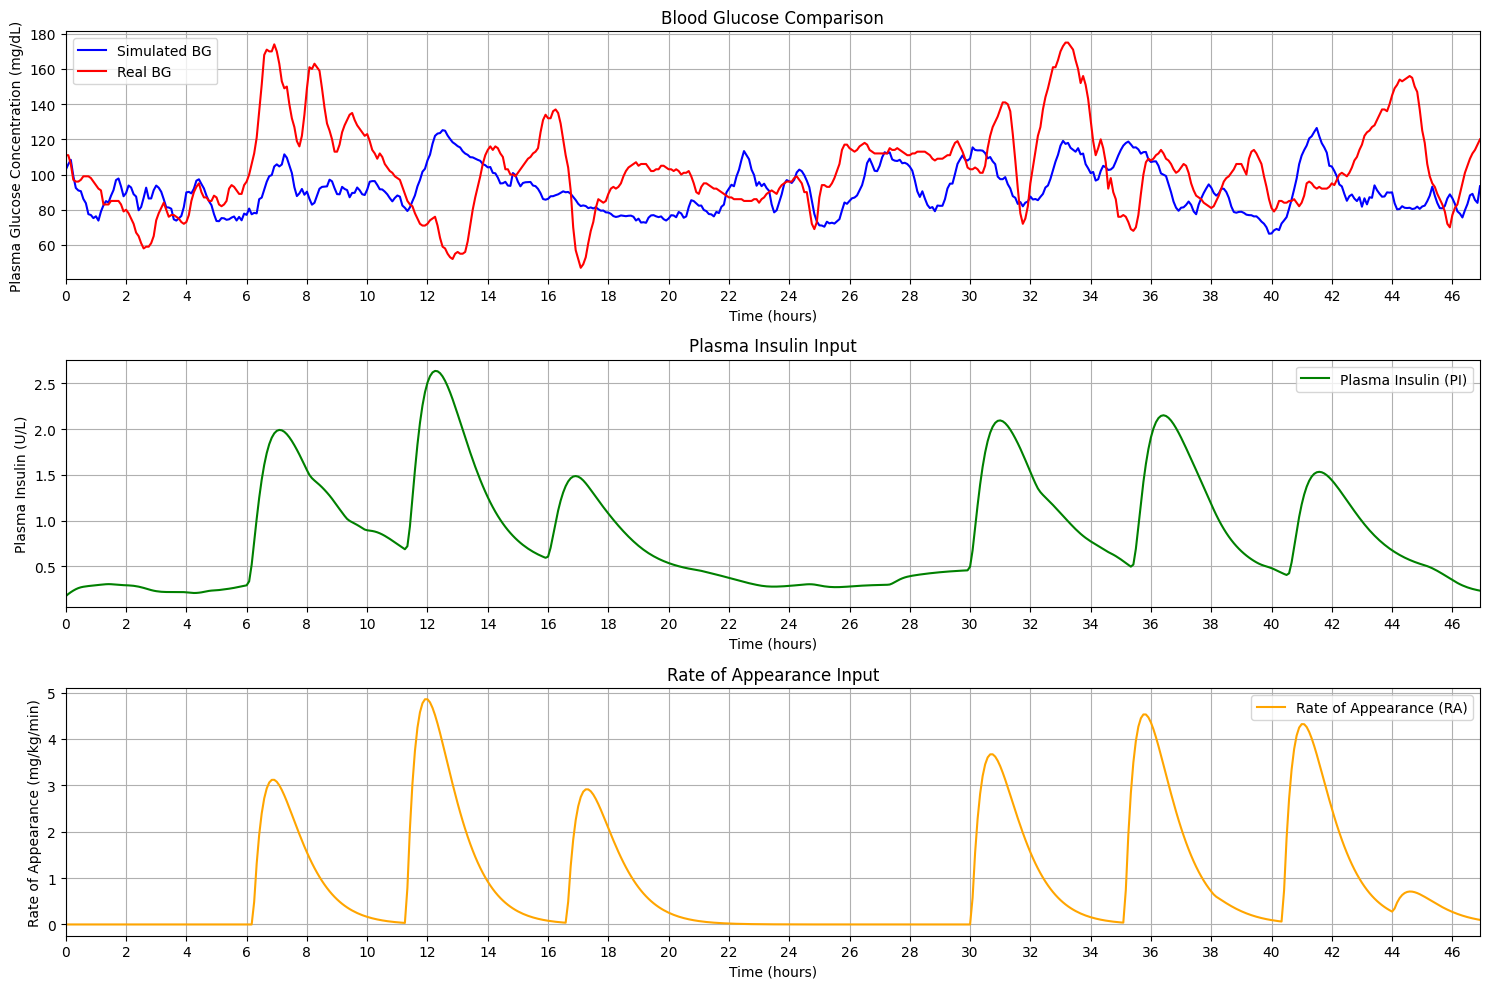

In [29]:
num_points = len(simulated_data.gen_bg_unscaled)
x_hours = np.arange(num_points) * 5 / 60  # 5 min per sample, convert to hours

plt.figure(figsize=(15, 10))

# First subplot: Blood glucose comparison
plt.subplot(3, 1, 1)
plt.plot(x_hours, simulated_data.gen_bg_unscaled, label='Simulated BG', color='blue')
plt.plot(x_hours, simulated_data.real_bg_unscaled, label='Real BG', color='red')
plt.xlabel('Time (hours)')
plt.ylabel('Plasma Glucose Concentration (mg/dL)')
plt.title('Blood Glucose Comparison')
plt.xticks(
    ticks=np.arange(0, x_hours[-1]+1, 2),
    labels=[f"{int(t)}" for t in np.arange(0, x_hours[-1]+1, 2)]
)
plt.xlim([0, x_hours[-1]])
plt.legend()
plt.grid(True)

# Second subplot: Plasma Insulin (PI)
plt.subplot(3, 1, 2)
plt.plot(x_hours, simulated_data.PI_unscaled.flatten(), label='Plasma Insulin (PI)', color='green')
plt.xlabel('Time (hours)')
plt.ylabel('Plasma Insulin (U/L)')
plt.title('Plasma Insulin Input')
plt.xticks(
    ticks=np.arange(0, x_hours[-1]+1, 2),
    labels=[f"{int(t)}" for t in np.arange(0, x_hours[-1]+1, 2)]
)
plt.xlim([0, x_hours[-1]])
plt.legend()
plt.grid(True)

# Third subplot: Rate of Appearance (RA)
plt.subplot(3, 1, 3)
plt.plot(x_hours, simulated_data.RA_unscaled.flatten(), label='Rate of Appearance (RA)', color='orange')
plt.xlabel('Time (hours)')
plt.ylabel('Rate of Appearance (mg/kg/min)')
plt.title('Rate of Appearance Input')
plt.xticks(
    ticks=np.arange(0, x_hours[-1]+1, 2),
    labels=[f"{int(t)}" for t in np.arange(0, x_hours[-1]+1, 2)]
)
plt.xlim([0, x_hours[-1]])
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [30]:
def calculate_metrics(bg_data, label):
    """Calculate metrics for a single BG array"""
    mean_bg = np.mean(bg_data)
    std_bg = np.std(bg_data)
    cv = (std_bg / mean_bg) * 100  # Coefficient of variation as percentage
    min_bg = np.min(bg_data)
    max_bg = np.max(bg_data)
    
    time_below_range = (np.sum(bg_data < 70) / len(bg_data)) * 100  # TBR
    time_in_range = (np.sum((bg_data >= 70) & (bg_data <= 180)) / len(bg_data)) * 100  # TIR
    time_above_range = (np.sum(bg_data > 180) / len(bg_data)) * 100  # TAR
    time_in_tight_range = (np.sum((bg_data >= 70) & (bg_data <= 140)) / len(bg_data)) * 100  # TITR
    
    return {
        f'Mean BG (mg/dL) - {label}': mean_bg,
        f'Std BG (mg/dL) - {label}': std_bg,
        f'CV (%) - {label}': cv,
        f'Min BG (mg/dL) - {label}': min_bg,
        f'Max BG (mg/dL) - {label}': max_bg,
        f'TBR (<70 mg/dL, %) - {label}': time_below_range,
        f'TIR (70-180 mg/dL, %) - {label}': time_in_range,
        f'TAR (>180 mg/dL, %) - {label}': time_above_range,
        f'TITR (70-140 mg/dL, %) - {label}': time_in_tight_range
    }

def compute_glycemic_metrics(simulated_data: SimulationData) -> pd.DataFrame:    
    real_bg = simulated_data.real_bg_unscaled
    sim_bg = simulated_data.gen_bg_unscaled
    
    min_length = min(len(real_bg), len(sim_bg))
    real_bg = real_bg[:min_length]
    sim_bg = sim_bg[:min_length]

    real_metrics = calculate_metrics(real_bg, 'Real')
    sim_metrics = calculate_metrics(sim_bg, 'Simulated')
    
    all_metrics = {**real_metrics, **sim_metrics}
    
    metrics_data = {
        'Metric': [],
        'Real': [],
        'Simulated': []
    }
    
    metric_names = [
        'Mean BG (mg/dL)',
        'Std BG (mg/dL)', 
        'CV (%)',
        'Min BG (mg/dL)',
        'Max BG (mg/dL)',
        'TBR (<70 mg/dL, %)',
        'TIR (70-180 mg/dL, %)',
        'TAR (>180 mg/dL, %)',
        'TITR (70-140 mg/dL, %)'
    ]
    
    for metric in metric_names:
        metrics_data['Metric'].append(metric)
        metrics_data['Real'].append(all_metrics[f'{metric} - Real'])
        metrics_data['Simulated'].append(all_metrics[f'{metric} - Simulated'])
    
    metrics_df = pd.DataFrame(metrics_data)
    
    metrics_df['Real'] = metrics_df['Real'].round(2)
    metrics_df['Simulated'] = metrics_df['Simulated'].round(2)
    
    return metrics_df

glycemic_metrics_table = compute_glycemic_metrics(simulated_data)
display(glycemic_metrics_table)

,Metric,Real,Simulated
0,Mean BG (mg/dL),103.43,91.62
1,Std BG (mg/dL),24.66,12.97
2,CV (%),23.84,14.15
3,Min BG (mg/dL),47.00,66.38
4,Max BG (mg/dL),175.00,126.47
5,"TBR (<70 mg/dL, %)",5.32,0.89
6,"TIR (70-180 mg/dL, %)",94.68,99.11
7,"TAR (>180 mg/dL, %)",0.00,0.00
8,"TITR (70-140 mg/dL, %)",85.99,99.11
